In [1]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error as mae

import sys
sys.path.append('/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/signal_decompositions/')
from utils import plot_decomp, plot_signal

# CVXPY
from solardatatools.signal_decompositions import make_l2_l1d2_constrained as cvx_sd
# OSD
from solardatatools.osd_signal_decompositions import make_l2_l1d2_constrained as osd_sd

np.random.seed(12) 
random.seed(10)

In [2]:
%load_ext autoreload
%autoreload 2

## `make_l2_l1d2`

### Create input signal

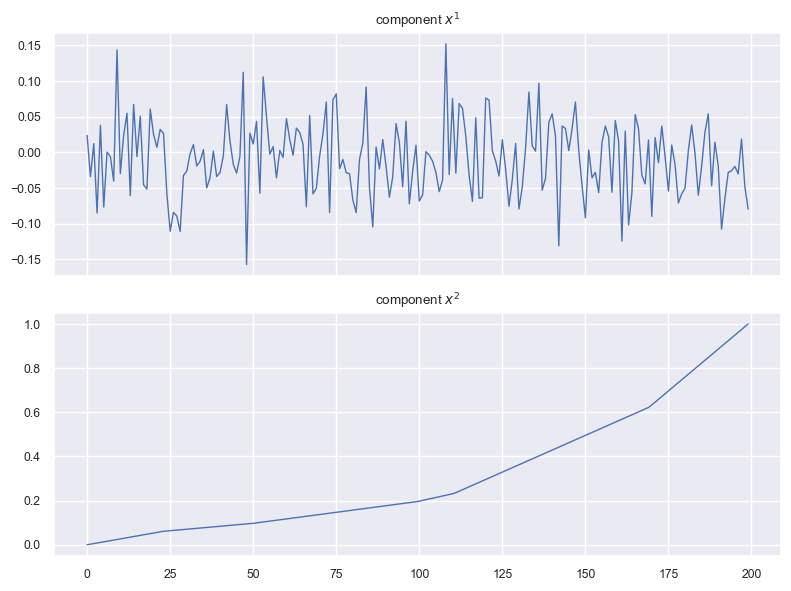

In [3]:
a = 4
b = [-2, 1, 2, 5, 9]
bpts = [23, 50, 100, 111, 170]
n_points = 200

noise = 0.05

x = np.linspace(0, 200, n_points)

y_points = a*x
for i in range(len(b)):
    y_points += b[i] * np.maximum(x - bpts[i], 0)
    
# normalize
y_points = (y_points-np.min(y_points))/(np.max(y_points)-np.min(y_points))

X_real = np.zeros((2, len(y_points)), dtype=float)
X_real[0] = np.random.normal(size=n_points) * noise
X_real[1] = y_points

y = np.sum(X_real, axis=0)




plot_decomp(X_real)

Data with missing values

In [5]:
indices_full = list(range(len(X_real[1])))
# select 20% randomly
indices_20perc = np.random.choice(indices_full, int(0.2*200), replace=False)

X_real_80perc = X_real.copy()
y_80perc = y.copy()

X_real_80perc[0][indices_20perc] = np.nan
X_real_80perc[1][indices_20perc] = np.nan
y_80perc[indices_20perc] = np.nan

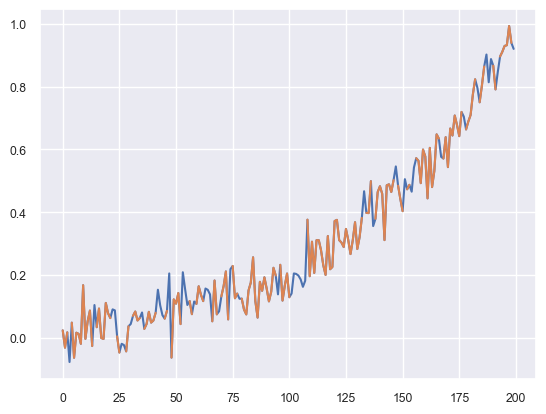

In [6]:
plt.plot(y)
plt.plot(y_80perc)

Data with missing chunks

In [7]:
indices_chunks_start = np.random.choice(indices_full, 5, replace=False)
X_real_chunks= X_real.copy()
y_chunks = y.copy()

for e in indices_chunks_start:
    for i in range(e, e+20):
        X_real_chunks[0][i] = np.nan
        X_real_chunks[1][i] = np.nan
        y_chunks[i] = np.nan

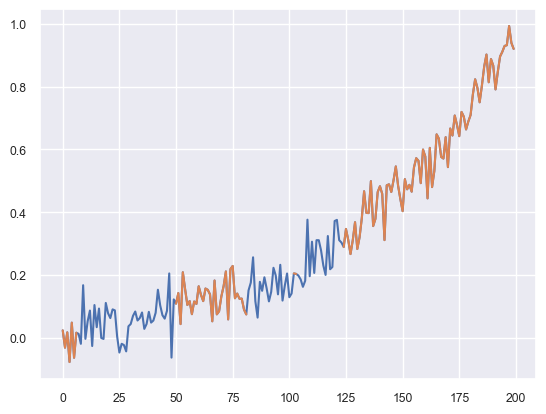

In [8]:
plt.plot(y)
plt.plot(y_chunks)

CVXPY objective       0.71712
OSD objective, scaled 0.71712
s_seas MAE (OSD+MOSEK,CVX)   1.56e-13
s_seas MAE (OSD+QSS,CVX)     3.66e-04


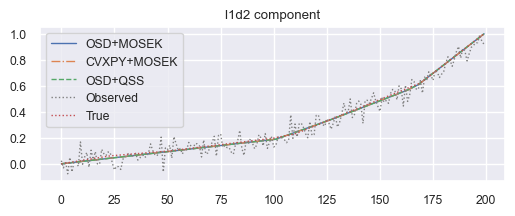

In [9]:
weight = {'weight' : 17}

osd_output = osd_sd(y, **weight, solver="MOSEK")
osd_qss_output = osd_sd(y, **weight, solver="QSS")

cvxpy_output = cvx_sd(y, **weight, solver="MOSEK", comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, **weight, solver="MOSEK", return_obj=True)[0]

print(f's_seas MAE (OSD+MOSEK,CVX)   {mae(osd_output, cvxpy_output):.2e}')
print(f's_seas MAE (OSD+QSS,CVX)     {mae(osd_qss_output, cvxpy_output):.2e}')

f, (ax1) = plt.subplots(1, 1, figsize=(6,2))
ax1.plot(osd_output, label="OSD+MOSEK", linewidth=1)
ax1.plot(cvxpy_output, label="CVXPY+MOSEK", linewidth=1, linestyle="-.")
ax1.plot(osd_qss_output, label="OSD+QSS", linewidth=1, linestyle="--")
ax1.plot(y, label="Observed", linestyle=":", linewidth=1, alpha=1, color="gray")
ax1.plot(X_real[1], label="True", linestyle=":", linewidth=1, alpha=1)

ax1.set_title("l1d2 component")
ax1.legend()
#plt.savefig("make_l2_l1d2_synt", dpi=300)

CVXPY objective       0.43935
OSD objective, scaled 0.43935
s_seas MAE (OSD,CVX)   6.67e-14


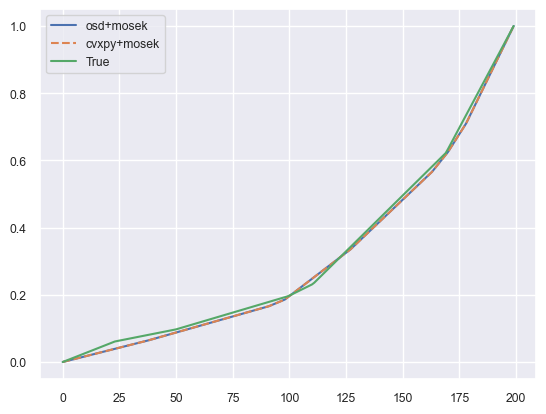

In [10]:
weight = {'weight' : 3}

osd_output = osd_sd(y_80perc, **weight, solver="MOSEK")
cvxpy_output = cvx_sd(y_80perc, **weight, solver="MOSEK", comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y_80perc, **weight, solver="MOSEK", return_obj=True)[0]

print(f's_seas MAE (OSD,CVX)   {mae(osd_output, cvxpy_output):.2e}')

f, (ax1) = plt.subplots(1, 1)
ax1.plot(osd_output, label="osd+mosek")
ax1.plot(cvxpy_output, label="cvxpy+mosek", linestyle="--")
ax1.plot(X_real[1], label="True")
ax1.legend();